### Cell 1 — Import Libraries & Setup

This cell loads all the required Python libraries used in this notebook:

- **pandas, numpy** → data processing  
- **matplotlib** → visual plots  
- **sklearn** → regression models & outlier detection  
- **IsolationForest** → used for anomaly detection  
- **Linear, Quadratic, Cubic models** → polynomial regression

It also creates a `/data` folder where the CSV file must be placed.

After running, the notebook prints a message telling the user where to put the CSV file.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest

os.makedirs("data", exist_ok=True)
print("Ready. Put your CSV inside: data/")


Ready. Put your CSV inside: data/


### Cell 2 — Load the CSV file from data/

This cell:

1. Defines the expected CSV location  
2. Checks if the file exists — otherwise raises an error  
3. Loads the CSV using `pd.read_csv()`  
4. Skips the first 2 rows because exports from Google Ads usually contain extra header info  
5. Prints dataset shape and previews the first rows

This ensures the raw dataset is successfully loaded into memory.


In [2]:
file_path = "data/Campaign budget analysis data export.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found at {file_path}. Place it in the data/ folder.")

df = pd.read_csv(file_path, skiprows=2)
print("CSV loaded. Shape:", df.shape)
df.head()

CSV loaded. Shape: (7370, 11)


,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
0,SBR Pravanika | Search | 25 Nov 22,NaN,19031976471,2000.0,0,0,INR,0.00,0,0.00,0.0
1,Valmark Cityville | Search | 25 Nov 22,22-11-24,19038490303,5000.0,0,0,INR,0.00,0,0.00,0.0
2,SBR Pravanika | Search | 25 Nov 22,2022-11-25,19031976471,2000.0,3,34,INR,411.98,8.82%,137.33,0.0
3,Valmark Cityville | Search | 25 Nov 22,2022-11-25,19038490303,5000.0,5,48,INR,870.50,10.42%,174.10,0.0
4,SBR Pravanika | Search | 25 Nov 22,2022-11-26,19031976471,2000.0,11,62,INR,1147.28,17.74%,104.30,2.0


### Cell 3 — Select important columns & clean numeric values

This step prepares your dataset for modeling:

- Renames `"Impr."` → `"Impressions"`  
- Keeps only required columns:
  - Impressions  
  - Clicks  
  - Conversions  
  - Cost  
- Removes commas (“1,200” → 1200)
- Removes percent symbols (“4.5%” → 4.5)
- Converts all values to numeric  
- Drops rows with missing values  

This results in a clean, numeric-only dataset ready for analysis.


In [3]:
df = df.rename(columns={
    "Impr.": "Impressions",
    "Day": "Date"
})

required_cols = ["Impressions", "Clicks", "Conversions", "Cost"]
df = df[required_cols].copy()

for col in required_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("%", "", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna()
print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (7370, 4)


,Impressions,Clicks,Conversions,Cost
0,0,0,0.0,0.00
1,0,0,0.0,0.00
2,34,3,0.0,411.98
3,48,5,0.0,870.50
4,62,11,2.0,1147.28


## 🧹 Sequential Outlier Detection and Visualization Pipeline

This section performs a complete outlier-removal workflow to clean the dataset before training predictive models.  
Outliers in advertising metrics (Impressions, Clicks, Conversions) can distort regression results, so we remove them **step-by-step**, ensuring each stage works with already-cleaned data.

---

### 🔍 1. Visualizing Inliers and Outliers  
The `plot_outlier_dots()` function draws a scatter plot showing:
- **Green** → Points retained after filtering (inliers)  
- **Red** → Points removed as outliers  
- Custom title showing how many outliers were detected  

This helps us visually confirm whether the outlier detection is reasonable for each metric.

---

### 🧪 2. Detecting Outliers for a Single Feature  
The `remove_outliers_pair()` function uses **IsolationForest** to detect anomalies for a specific feature paired with cost:

- Impressions vs Cost  
- Clicks vs Cost  
- Conversions vs Cost  

It returns:
- The filtered DataFrame  
- The count of removed outliers  

IsolationForest is suitable for marketing data because it identifies unusual patterns without assuming a particular distribution.

---

### 🔄 3. Sequential Outlier Removal  
The `show_outlier_report()` function performs outlier removal in **three ordered steps**, each using the cleaned output of the previous step:

1. **Step 1 — Impressions vs Cost**  
   Removes rows where impressions behave abnormally relative to cost.

2. **Step 2 — Clicks vs Cost**  
   Removes click-related outliers, using the already cleaned data from Step 1.

3. **Step 3 — Conversions vs Cost**  
   Removes conversion-related outliers, using data cleaned by Steps 1 and 2.

Each step also generates a visual scatter plot for transparency.

This ensures:
- Outliers removed at an earlier step do not interfere with later detection  
- Each metric is evaluated fairly  
- The dataset becomes progressively cleaner and more reliable for modeling  

Finally, the function prints:
- Row count before cleaning  
- Row count after each step  
- Final remaining dataset size  

It returns:
- `imp_clean` → After Impression outliers  
- `clicks_clean` → After Click outliers  
- `conv_clean` → After Conversion outliers (final cleaned data)

---

### ▶️ 4. Running the Complete Outlier Pipeline  
The last line executes the entire sequential cleaning process and stores the cleaned datasets for later modeling:

```python
imp_clean, clicks_clean, conv_clean = show_outlier_report(df)



📊 SEQUENTIAL OUTLIER REMOVAL PROCESS


BEFORE OUTLIERS REMOVED: 7370

--- Step 1: Impressions vs Cost ---


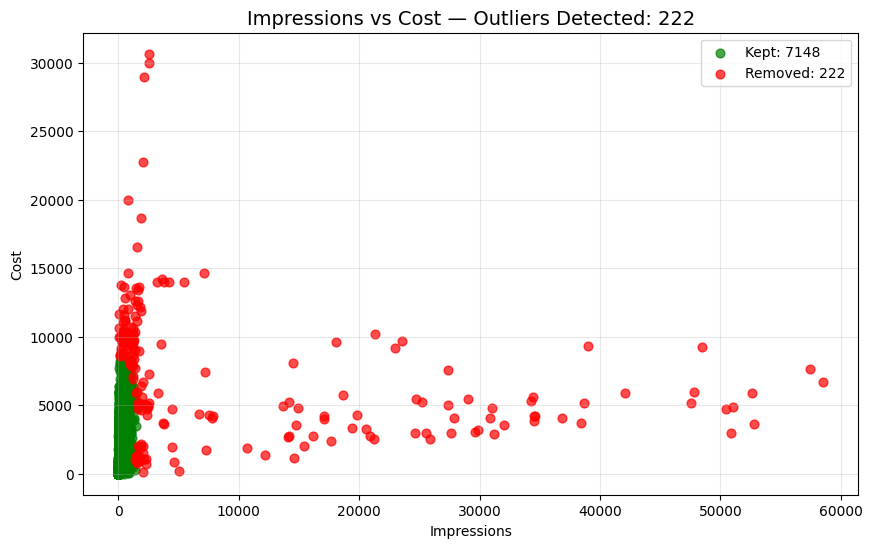


--- Step 2: Clicks vs Cost ---


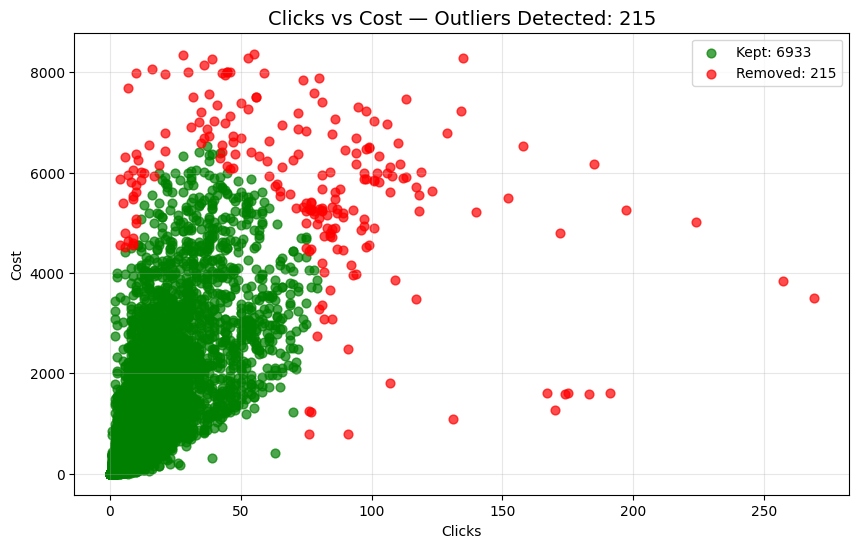


--- Step 3: Conversions vs Cost ---


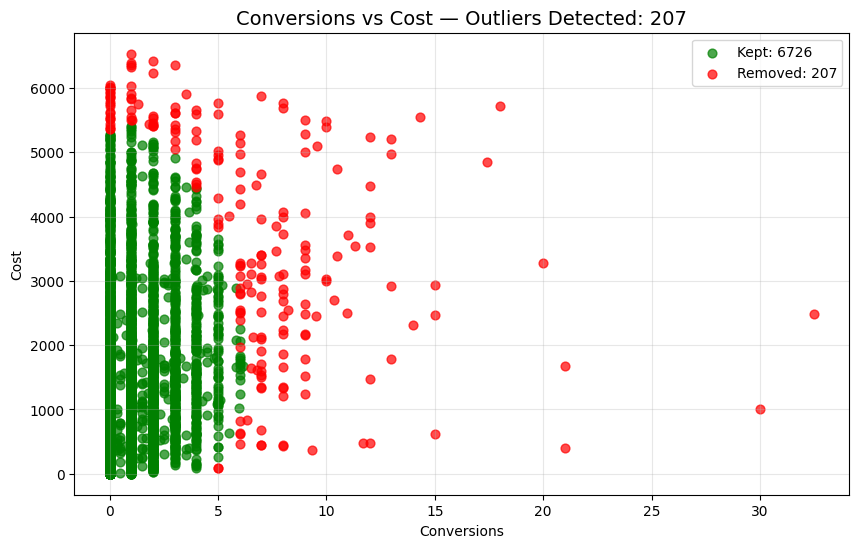


FINAL ROW COUNT AFTER ALL OUTLIERS REMOVED: 6726


,Impressions,Clicks,Conversions,Cost
0,0,0,0.0,0.00
1,0,0,0.0,0.00
2,34,3,0.0,411.98
3,48,5,0.0,870.50
4,62,11,2.0,1147.28


In [4]:
def plot_outlier_dots(before_df, after_df, x_col, removed_count):
    plt.figure(figsize=(10, 6))

    plt.scatter(
        after_df[x_col], after_df["Cost"],
        color="green", alpha=0.7, s=40,
        label=f"Kept: {len(after_df)}"
    )

    removed_df = before_df.loc[~before_df.index.isin(after_df.index)]
    plt.scatter(
        removed_df[x_col], removed_df["Cost"],
        color="red", alpha=0.7, s=40,
        label=f"Removed: {removed_count}"
    )

    plt.title(f"{x_col} vs Cost — Outliers Detected: {removed_count}", fontsize=14)

    plt.xlabel(x_col)
    plt.ylabel("Cost")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()



def remove_outliers_pair(df, x_col, contamination=0.03):

    iso = IsolationForest(contamination=contamination, random_state=42)

    pair = df[[x_col, "Cost"]]

    mask = iso.fit_predict(pair) == 1
    filtered = df[mask]
    removed = len(df) - len(filtered)

    return filtered, removed



def show_outlier_report(df):
    print("\n📊 SEQUENTIAL OUTLIER REMOVAL PROCESS\n")
    print("\nBEFORE OUTLIERS REMOVED:", len(df))


    print("\n--- Step 1: Impressions vs Cost ---")
    df1, removed_imp = remove_outliers_pair(df, "Impressions")
    plot_outlier_dots(df, df1, "Impressions", removed_imp)


    print("\n--- Step 2: Clicks vs Cost ---")
    df2, removed_clicks = remove_outliers_pair(df1, "Clicks")
    plot_outlier_dots(df1, df2, "Clicks", removed_clicks)


    print("\n--- Step 3: Conversions vs Cost ---")
    df3, removed_conv = remove_outliers_pair(df2, "Conversions")
    plot_outlier_dots(df2, df3, "Conversions", removed_conv)


    print("\nFINAL ROW COUNT AFTER ALL OUTLIERS REMOVED:", len(df3))

    return df1, df2, df3


imp_clean, clicks_clean, conv_clean = show_outlier_report(df)

df_clean = conv_clean.copy()
df_clean.head()



## 🧩 Preparing Training Data & Training Regression Models

To begin modeling, we first prepare the cleaned dataset by separating:

### **Features (X):**
- Impressions  
- Clicks  
- Conversions  

### **Target (y):**
- Cost  

These features are used to predict the advertising cost using regression models.

---

## 🤖 Model Training Overview

We train three different regression models to understand the relationship between the input features and cost:

### **1️⃣ Linear Regression**  
- Assumes a straight-line relationship  
- Works well when cost changes proportionally with impressions/clicks/conversions  

### **2️⃣ Quadratic Regression (Degree = 2)**  
- Captures curved or nonlinear patterns  
- Useful when cost increases/decreases at varying rates  

### **3️⃣ Cubic Regression (Degree = 3)**  
- Allows even more complex curves  
- May overfit noisy marketing data  
- Included for comparison and analysis  

All three models are trained using the same cleaned dataset to ensure fair comparison.


In [5]:
X = df_clean[["Impressions", "Clicks", "Conversions"]].values
y = df_clean["Cost"].values

linear_model = LinearRegression()
linear_model.fit(X, y)


quad_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
quad_model.fit(X, y)


cubic_model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression()
)
cubic_model.fit(X, y)


print("Linear, Quadratic, and Cubic models trained.")


Linear, Quadratic, and Cubic models trained.


## 📊 Daily Cost & Total Cost Prediction (Using ML Models)

This cell predicts the **daily advertising cost** and the **total cost for a selected number of days** based on user-provided inputs:
- **Impressions**
- **Clicks**
- **Conversions**
- **Duration (days)**

The trained models (Linear, Quadratic, Cubic) estimate how these metrics influence campaign cost.

---

### **1. User Inputs**
The user provides:
- Target impressions per day  
- Expected clicks per day  
- Expected conversions per day  
- Duration of the ad campaign in days  

These inputs are passed to the models for prediction.

---

### **2. Daily Cost Prediction**
Each model predicts the **cost per day**:

- **Linear Regression** — simplest, assumes straight-line relationship  
- **Quadratic Regression** — captures curved patterns  
- **Cubic Regression** — captures more complex relationships (risk of overfitting)

---

### **3. Total Cost Calculation**
The daily predicted cost is multiplied by the chosen duration:

\[
\text{Total Cost} = \text{Daily Cost} \times \text{Number of Days}
\]

---

### **4. Printed Output**
The cell displays:

- User-entered inputs  
- Daily cost predicted by each model  
- Total cost for the given duration  

This helps decide which model gives the most stable and realistic prediction.

---


In [6]:
user_impressions = 300
user_clicks = 50
user_conversions = 6
user_duration_days = 7

user_X = [[user_impressions, user_clicks, user_conversions]]

daily_linear = linear_model.predict(user_X)[0]
daily_quad   = quad_model.predict(user_X)[0]
daily_cubic  = cubic_model.predict(user_X)[0]

total_linear = daily_linear * user_duration_days
total_quad   = daily_quad * user_duration_days
total_cubic  = daily_cubic * user_duration_days

print("USER INPUTS")
print("Impressions:", user_impressions)
print("Clicks:", user_clicks)
print("Conversions:", user_conversions)
print("Duration (days):", user_duration_days)

print("\n DAILY COST PREDICTION")
print("Linear     :", daily_linear)
print("Quadratic  :", daily_quad)
print("Cubic      :", daily_cubic)

print("\n TOTAL COST FOR", user_duration_days, "DAYS")
print("Linear Total     :", total_linear)
print("Quadratic Total  :", total_quad)
print("Cubic Total      :", total_cubic)


USER INPUTS
Impressions: 300
Clicks: 50
Conversions: 6
Duration (days): 7

 DAILY COST PREDICTION
Linear     : 3263.2610419945095
Quadratic  : 2614.8602580308307
Cubic      : 2311.726372840325

 TOTAL COST FOR 7 DAYS
Linear Total     : 22842.827293961567
Quadratic Total  : 18304.021806215816
Cubic Total      : 16182.084609882275


## 📈 Visualizing Feature Influence on Cost (Partial Dependence)

To understand how each feature affects cost individually:

- We vary **one** feature across its range  
- Hold the other two features fixed at their **median values**  
- Plot predictions of: Linear, Quadratic, Cubic models  

This reveals:
- Whether relationships are linear or curved  
- Extrapolation issues (especially cubic)  
- Model stability for impressions, clicks, conversions  


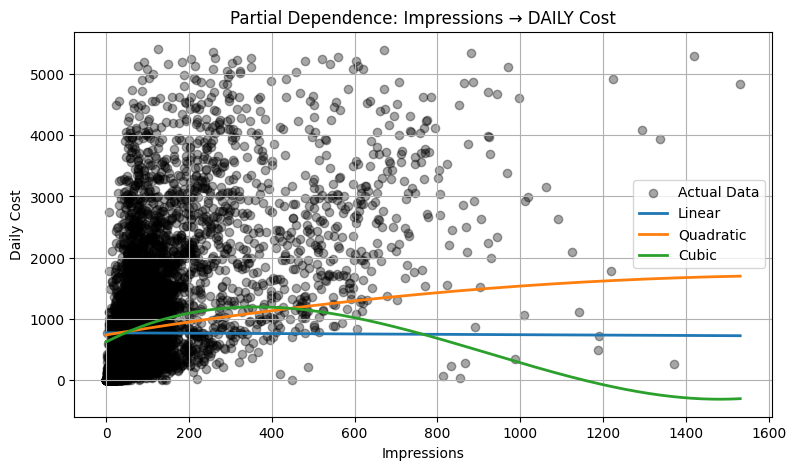

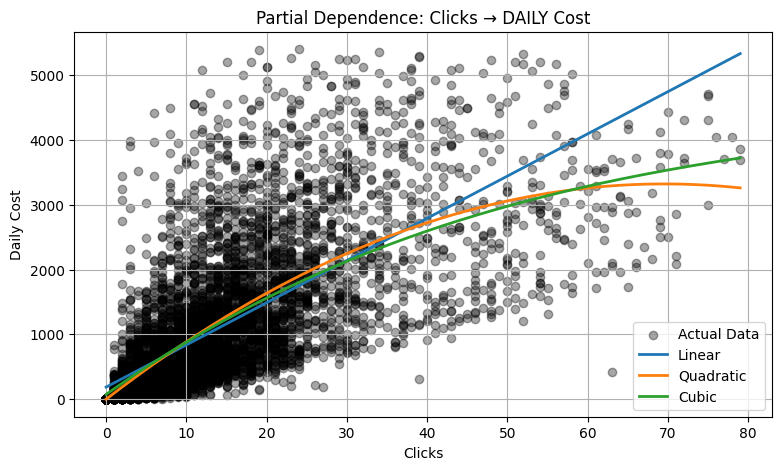

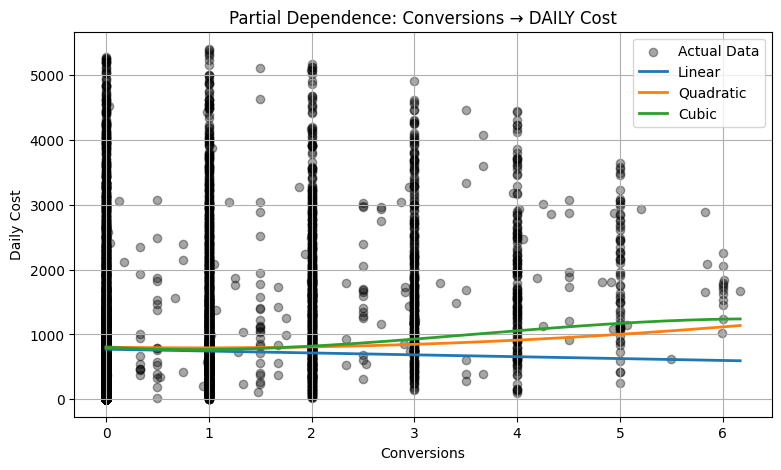

In [7]:
fixed_impressions = df_clean["Impressions"].median()
fixed_clicks = df_clean["Clicks"].median()
fixed_conversions = df_clean["Conversions"].median()

features = ["Impressions", "Clicks", "Conversions"]

for feature in features:
    X_range = np.linspace(df_clean[feature].min(), df_clean[feature].max(), 300)

    if feature == "Impressions":
        X_plot = np.column_stack([
            X_range,
            np.full_like(X_range, fixed_clicks),
            np.full_like(X_range, fixed_conversions)
        ])
        actual_x = df_clean["Impressions"]

    elif feature == "Clicks":
        X_plot = np.column_stack([
            np.full_like(X_range, fixed_impressions),
            X_range,
            np.full_like(X_range, fixed_conversions)
        ])
        actual_x = df_clean["Clicks"]

    else:
        X_plot = np.column_stack([
            np.full_like(X_range, fixed_impressions),
            np.full_like(X_range, fixed_clicks),
            X_range
        ])
        actual_x = df_clean["Conversions"]

    plt.figure(figsize=(9, 5))
    plt.scatter(actual_x, y, color="black", alpha=0.35, label="Actual Data")

    plt.plot(X_range, linear_model.predict(X_plot), label="Linear", linewidth=2)
    plt.plot(X_range, quad_model.predict(X_plot), label="Quadratic", linewidth=2)
    plt.plot(X_range, cubic_model.predict(X_plot), label="Cubic", linewidth=2)

    plt.title(f"Partial Dependence: {feature} → DAILY Cost")
    plt.xlabel(feature)
    plt.ylabel("Daily Cost")
    plt.grid(True)
    plt.legend()
    plt.show()


## 📊 Model Evaluation: RMSE and R² Comparison

We evaluate each model using metrics:

### ✔ RMSE (Root Mean Squared Error)  
Lower RMSE = better prediction accuracy.

### ✔ R² Score  
Higher R² = model explains more variance.

We generate a table showing:
- RMSE  
- R²  
- Predicted cost for the example input  


In [8]:
def evaluate(model, X, y):
    pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    return rmse, r2

total_col_name = f"Total Cost for {user_duration_days} Days"

results = pd.DataFrame({
    "Model": ["Linear", "Quadratic", "Cubic"],
    "RMSE": [
        evaluate(linear_model, X, y)[0],
        evaluate(quad_model, X, y)[0],
        evaluate(cubic_model, X, y)[0]
    ],
    "R²": [
        evaluate(linear_model, X, y)[1],
        evaluate(quad_model, X, y)[1],
        evaluate(cubic_model, X, y)[1]
    ],
    "Predicted Daily Cost": [
        daily_linear,
        daily_quad,
        daily_cubic
    ],
    total_col_name: [
        total_linear,
        total_quad,
        total_cubic
    ]
})

print(results)

best = results.sort_values(["RMSE", "R²"], ascending=[True, False]).iloc[0]["Model"]
print("\n✅ Recommended Model:", best)


       Model        RMSE        R²  Predicted Daily Cost  \
0     Linear  778.309813  0.509970           3263.261042   
1  Quadratic  738.567038  0.558737           2614.860258   
2      Cubic  734.273666  0.563853           2311.726373   

   Total Cost for 7 Days  
0           22842.827294  
1           18304.021806  
2           16182.084610  

✅ Recommended Model: Cubic
